In [1]:
cd ../

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [2]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob

# Create a RA DEC text file in the right format

In [45]:
df = pd.read_csv('Cep-I/SIMBAD_CepheidType1s.tsv', sep='\t', skiprows=4).drop(0).reset_index(drop=True)

In [46]:
hms = [r.split() for r in df['       coord1 (ICRS,J2000/2000)        ']]

In [48]:
with open('Cep-I/Cep-I.txt', 'w') as f:
    for o in hms:
        ra = "{0}h{1}m{2}s".format(o[0], o[1], o[2])
        dec = "{0}d{1}m{2}s".format(o[3], o[4], o[5])

        c = SkyCoord(ra, dec, frame='icrs')
        
        ra_deg = c.ra.deg
        dec_deg = c.dec.deg

        line = "{0} \t {1} \t 1".format(ra_deg, dec_deg)
        f.write(line)
        f.write('\n')

In [66]:
o = "08 10 49.3237950601  -47 41 54.827371638".split()

In [67]:
ra = "{0}h{1}m{2}s".format(o[0], o[1], o[2])
dec = "{0}d{1}m{2}s".format(o[3], o[4], o[5])

c = SkyCoord(ra, dec, frame='icrs')
        
ra_deg = c.ra.deg
dec_deg = c.dec.deg

In [68]:
ra_deg, dec_deg

(122.70551581275039, -47.69856315878833)

# Spectra

Couldn't find any spectra in the FAST SPECTRAL ARCHIVE using the ra and dec values that Paul got from his SIMBAD query. 

So, we got one from Jozsef Vinko, AX Velorum, a classical Cepheid.

In [98]:
spec = pd.read_csv("Cep-I/Cep-I_spec", sep=" ", names=["wavelength", "flux"])

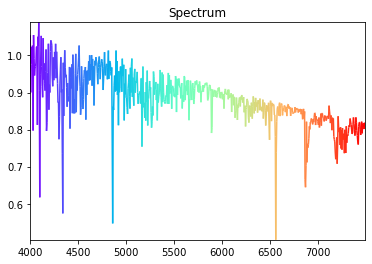

In [99]:
#raw data
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = spec['wavelength'], spec['flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

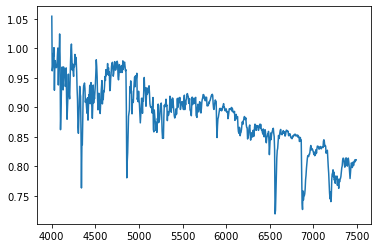

In [108]:
plt.plot(spec['wavelength'], spec['flux'].ewm(span = 5).mean())

In [109]:
spec['flux'] = spec['flux'].ewm(span = 5).mean()

In [110]:
preproc_spec = spectra_preproc(spec, bins=np.arange(4000,7500,10))

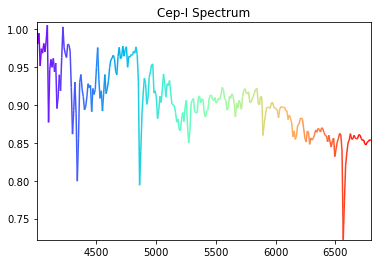

In [113]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(x.min(), 6800)
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), 6800)
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Cep-I Spectrum')
plt.show()

# Light Curve

In [63]:
# object name (or abbreviation)
n = "Cep-I"

# resample length for time-sorted LC purposes
resample_len = '4d'

lc_path= "Cep-I/ASAS_SN_Cep-I_LC.csv"

In [64]:
lc = pd.read_csv(lc_path)

In [65]:
lc['mjd'] = jd.jd_to_mjd(lc['hjd'])
lc.loc[lc['mag'] > 8.7, 'mag'] = np.nan

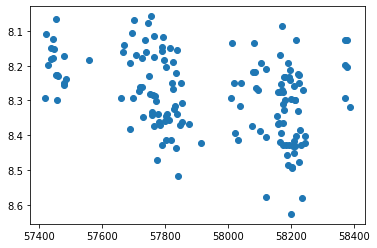

In [66]:
#raw data
plt.scatter(lc['mjd'], lc['mag'])
plt.gca().invert_yaxis()

In [71]:
lc.to_csv("Cep-I/lc.csv")

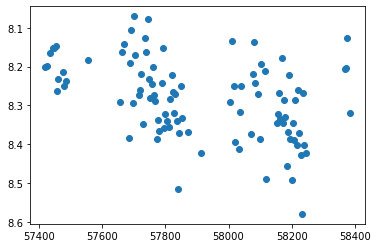

In [72]:
# #resampled data
# lc.rename(columns={'hjd':'mjd'}, inplace=True)
time_preproc_lc = LC_timesort_preproc(lc, resample_len=resample_len)
time_preproc_lc.loc[time_preproc_lc['Magnitude'] > 9, 'Magnitude'] = np.nan
plt.scatter(time_preproc_lc['Modified Julian Day'], time_preproc_lc['Magnitude'])
plt.gca().invert_yaxis()

In [73]:
#number of days video covers
len(lc)

157

In [74]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc) / 8.5), "s")

Estimated video time of 28.470588235294116 s


In [103]:
lc_path = "Cep-I/lc.csv"

In [104]:
#load data into astropy table, sort by mjd, and remove phase
data = ascii.read(lc_path, format='csv', fast_reader=False)
data['mjd'] = jd.jd_to_mjd(data['hjd'])
data.sort('mjd')

#Use LombScargle periodogram to find the best fit period (in days)
omega = LCtools.perdiodSearch(data)[0]['P'] 

print("The period is", omega, "days")

The period is 1.296680497925311 days


In [105]:
#restructure data for input to AFD
data_tuple = (data['mjd'], data['mag'], data['magerr'],)


data['phase'] = LCtools.AFD(data_tuple, omega)[3]

In [95]:
data.sort('phase')

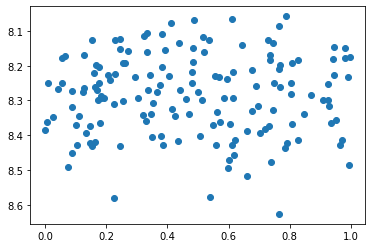

In [96]:
plt.scatter(data['phase'], data['mag'])
plt.gca().invert_yaxis()

In [106]:
data.write('Cep-I/lc.csv', format='ascii.csv', overwrite=True)

In [107]:
phasefit_preproc_lc = LC_phasefit_preproc('Cep-I/lc.csv', bins=phase_bins())

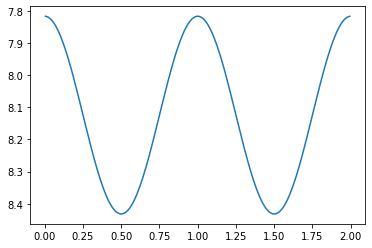

In [108]:
plt.plot(phasefit_preproc_lc['Phase'], phasefit_preproc_lc['Magnitude'])
plt.gca().invert_yaxis()

/Users/joepalmo/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/joepalmo/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'ZTF g mag')

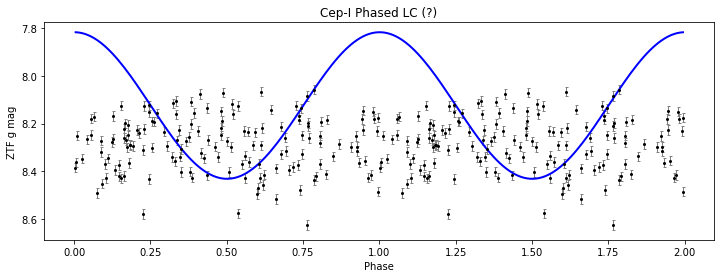

In [110]:
fig = plt.figure(figsize=(12,4))
plt.errorbar(data['phase'], data['mag'], data['magerr'], fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5)
plt.errorbar(data['phase']+1, data['mag'], data['magerr'], fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5)
plt.plot(phasefit_preproc_lc['Phase'], phasefit_preproc_lc['Magnitude'], 'b', markeredgecolor='b', lw=2, fillstyle='top', linestyle='solid')
plt.gca().invert_yaxis()
plt.title("Cep-I Phased LC (?)")
plt.xlabel("Phase")
plt.ylabel("ZTF g mag")